In [5]:
# plot mirror-symmetric viewpoint tuning
# useful packages:
import torch
import torchvision.transforms as transforms
from torchvision import models
from scipy import stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
import pickle
from PIL import Image
import random
import matplotlib.gridspec as gridspec
import seaborn as sns

In [6]:
# settings
ncatg = 9
nview = 9
nexemplar = 25
num_imgs = nexemplar * nview * ncatg # number of images
img_size = 227
nchannel = 3
# line colors
cmap = np.divide([[166,206,227],
        [31,120,180],
        [178,223,138],
        [51,160,44],
        [253,191,111],
        [255,127,0],
        [202,178,214],
        [251,154,153],
        [227,26,2]],255)

catg_names = ['car','boat','face','chair','airplane','tool','animal','fruit','flower']

# font
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 6
plt.rcParams['axes.linewidth'] = 0.8

# Initialize the grid with 1 rows and 1 columns
ncols = 3
nrows = 3
grid = gridspec.GridSpec(nrows, ncols,
            left=0.05, bottom=0.1, right=0.95, top=0.91, wspace=0.23, hspace=0.3)

# figure 
msz = 3
lw = 1
y_pos = [-0.5, 0, 0.5, 1]

model_dir = 'msvt/'

In [7]:
# load models' msvt
model_names = ['HMAX','VGGFace','VGG16','AlexNet','EIG','ResNet50','ConvNeXt','ViT']
max_layer = np.empty((len(model_names),ncatg))
std_max_layer = np.empty((len(model_names),ncatg))

mean_layer = np.empty((len(model_names),ncatg))
std_mean_layer = np.empty((len(model_names),ncatg))

name_max_layer = np.empty((len(model_names),ncatg),dtype='U20')
for i_model, name in enumerate(model_names):
    if name is 'VGG16' or name is 'VGGFace' or name is 'AlexNet':
        # matlab
        data = scipy.io.loadmat(f'{model_dir}msvt_index_{name}')
        nlayer = data['msvt'].T.shape[0]
        data['msvt'] = data['msvt'].T
        layer_name = []
        for i_layer in range(0,nlayer):
            if name is 'AlexNet':
                layer_name.append(data['name'][i_layer][0][0])
            else:
                layer_name.append(data['name'][0][i_layer][0])
    else:
        # python
        with open(f'{model_dir}msvt_index_{name}.pkl', 'rb') as f:
            data = pickle.load(f)
            if name == 'ResNet50' or name == 'ViT' or name == 'ConvNeXt' or name == 'AlexNet':
                with open(f'{model_dir}msvt_index_HMAX.pkl', 'rb') as f:
                    tmp =  pickle.load(f)
                    data['msvt'] = [tmp['msvt'][0]] + data['msvt']
                    data['name'] = [tmp['name'][0]] + data['name']

        nlayer = len(data['msvt'])
        layer_name = data['name']

    # catg msvt
    mean_catg_index = np.empty((ncatg,nlayer))
    std_catg_index = np.empty((ncatg,nlayer))
    for i_catg in range(0,ncatg):
        for i_layer in range(0,nlayer):
            msvt_catg = data['msvt'][i_layer][i_catg * nexemplar : (i_catg + 1) * nexemplar]
            mean_catg_index[i_catg,i_layer] = np.mean(msvt_catg)
            std_catg_index[i_catg,i_layer] = np.std(msvt_catg)/np.sqrt(nexemplar)
        
        idx = np.argmax(mean_catg_index[i_catg])
        mean_layer[i_model,i_catg] = np.mean(mean_catg_index[i_catg])
        max_layer[i_model,i_catg] = mean_catg_index[i_catg][idx] #- mean_catg_index[i_catg][0]
        std_max_layer[i_model,i_catg] = std_catg_index[i_catg][idx] #- mean_catg_index[i_catg][0]
        name_max_layer[i_model,i_catg] = layer_name[idx]

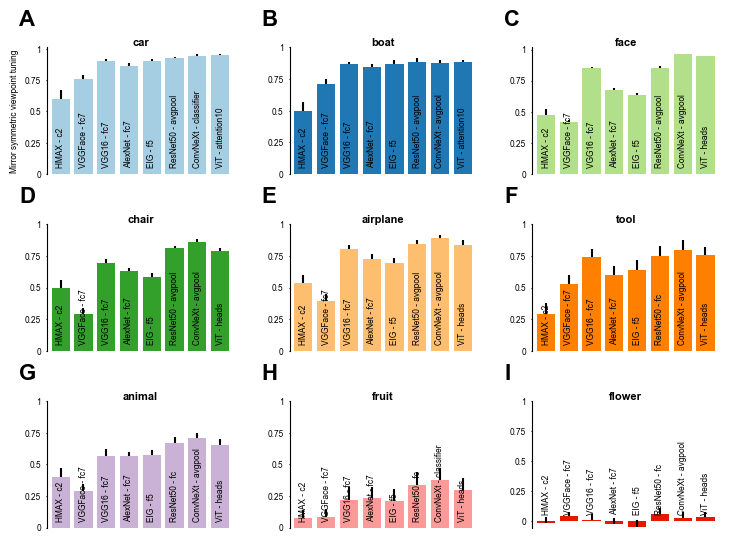

In [8]:
# plot the figure
figname = 'figureS9'
fig = plt.figure(figsize=(7,5))
ncols = 3
nrows = 3
gs = gridspec.GridSpec(nrows, ncols, left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.3, hspace=0.4)
labels = ['A','B','C','D','E','F','G','H','I']

x_pos = np.arange(0, len(model_names), 1)  # This will give values for each degree
for i, ax_ in enumerate(gs):
    ax = fig.add_subplot(ax_,zorder=2)

    ax.bar(x_pos, max_layer[:,i], yerr = [np.zeros(len(std_max_layer[:,i])), std_max_layer[:,i]], color=cmap[i],capsize=0,width=0.8,clip_on=False)
    
    for i_bar, bar in enumerate(ax.patches):
       ax.text(bar.get_x()+bar.get_width()/2,0.05,f'{model_names[i_bar]} - {name_max_layer[i_bar,i]}',color='k', ha ='center', va='bottom',rotation=90,fontsize=6,fontweight= 'normal')

    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xlim([x_pos[0]-0.6,x_pos[-1]+0.6])
    # ax.set_ylim([0,1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_title(catg_names[i],pad = -10,
                      fontdict = {'fontsize': 8,
                         'fontweight': 'bold',
                         'color': [0,0,0],
                         'verticalalignment': 'center',
                         'horizontalalignment': 'center'})

    if i is 0:
        ax.set_ylabel('Mirror symmetric viewpoint tuning')

    ax.text(-0.15,1.3, labels[i],transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
    # font and tick params
    plt.tick_params(length = 1, width = 0.8)
    mpl.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.linewidth'] = 0.8

plt.tight_layout()
plt.savefig(figname+'.pdf',dpi=300,bbox_inches='tight',facecolor='w',pad_inches=0)
plt.show()